# Notebook 03 — Modeling & Export

**Goal:** Train baseline (LogReg, RF), tune RF, evaluate, and export the best pipeline.  
**Input:** `../data/processed/hr_attrition_ready.parquet`  
**Outputs:** `../artifacts/v1/rf_pipeline.joblib`, `../artifacts/v1/features.json`  


In [4]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import json
import joblib

# Import from src modules for consistency
import sys
sys.path.append(str(Path.cwd().parent))  # Add project root to path

from src.features import NUM_FEATURES, CAT_FEATURES
from src.pipeline import make_logreg_pipeline, make_rf_pipeline
from src.config import READY_PARQUET, ARTIFACTS_DIR

print("✅ All libraries and modules imported")

# Load data using config
df = pd.read_parquet(READY_PARQUET)
print(f"✅ Loaded ready data: {df.shape}")
print(f"   From: {READY_PARQUET}")

# Use features from src.features module
NUM = NUM_FEATURES
CAT = CAT_FEATURES
print(f"✅ Using {len(NUM)} numeric and {len(CAT)} categorical features")

X = df[NUM + CAT]
y = df["target"]

Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Use built-in round() for floats
print("Class balance:", {
    "train": round(float(ytr.mean()), 3),
    "test":  round(float(yte.mean()), 3)
})

# Use pipeline builders from src.pipeline module
# This ensures consistent preprocessing across all notebooks and the dashboard
logreg = make_logreg_pipeline(NUM, CAT)
rf = make_rf_pipeline(NUM, CAT)

print("✅ Created pipelines using src.pipeline module")
print("   - Logistic Regression pipeline ready")
print("   - Random Forest pipeline ready")

# Quick baseline comparison on TEST
for name, model in [("LogReg", logreg), ("RF", rf)]:
    model.fit(Xtr, ytr)
    probs = model.predict_proba(Xte)[:,1]
    preds = (probs >= 0.50).astype(int)
    auc = roc_auc_score(yte, probs)
    print(f"\n=== {name} ===")
    print("ROC-AUC:", round(auc, 3))    
    print(classification_report(yte, preds))
    print("Confusion matrix:\n", confusion_matrix(yte, preds))

✅ All libraries and modules imported
✅ Loaded ready data: (1470, 36)
   From: /Users/ahmedgodah/Documents/vscode-projects/AttriSight/data/processed/hr_attrition_ready.parquet
✅ Using 7 numeric and 8 categorical features
Class balance: {'train': 0.162, 'test': 0.16}
✅ Created pipelines using src.pipeline module
   - Logistic Regression pipeline ready
   - Random Forest pipeline ready

=== LogReg ===
ROC-AUC: 0.777
              precision    recall  f1-score   support

           0       0.87      0.97      0.91       247
           1       0.56      0.21      0.31        47

    accuracy                           0.85       294
   macro avg       0.71      0.59      0.61       294
weighted avg       0.82      0.85      0.82       294

Confusion matrix:
 [[239   8]
 [ 37  10]]

=== RF ===
ROC-AUC: 0.764
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       247
           1       0.43      0.19      0.26        47

    accuracy           

In [ ]:
# Grid search for RF (AUC, 5-fold). Heavy but thorough.
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

param_grid = {
    "clf__n_estimators": [100, 300, 500],
    "clf__max_depth": [None, 8, 16],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2", None],
    "clf__criterion": ["gini", "entropy", "log_loss"]
}

rf = Pipeline([("pre", preproc(NUM, CAT)),
              ("clf", RandomForestClassifier(random_state=42))])

grid = GridSearchCV(
    rf, param_grid=param_grid, scoring="roc_auc", cv=5,
     n_jobs=-1, verbose=1)
grid.fit(Xtr, ytr)

best = grid.best_estimator_
test_auc = roc_auc_score(yte, best.predict_proba(Xte)[:, 1])

print("Best params:", grid.best_params_)
print("Test ROC-AUC (best):", round(test_auc, 3))

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


Traceback (most recent call last):
  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 112, in _get_module_details
  File "/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/joblib/__init__.py", line 120, in <module>
Traceback (most recent call last):
  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 112, in _get_module_details
  File "/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/joblib/__init__.py", line 115, in <module>
Traceback (most recent call last):
  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 112, in _get_module_details
  File "/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/joblib/__init__.py", line 120, in <module>
Traceback (most recent call last):
Traceback (most recent call last):
  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 189, in _run_module_as_main
  File 

KeyboardInterrupt: 

In [2]:
#Smaller grid (faster). Use this instead of Cell 2 if timing matters
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

small_grid = {
    "clf__n_estimators": [150, 300],
    "clf__max_depth": [None, 12],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
    "clf__max_features": ["sqrt", "log2"],
    "clf__criterion": ["gini", "entropy"],
}
rf = Pipeline([("pre", preproc(NUM, CAT)),
              ("clf", RandomForestClassifier(random_state=42))])

grid = GridSearchCV(rf, param_grid=small_grid, scoring="roc_auc", cv=3,
     n_jobs=-1, verbose=1)
grid.fit(Xtr, ytr)

best = grid.best_estimator_
test_auc = roc_auc_score(yte, best.predict_proba(Xte)[:, 1])
print("Best params:", grid.best_params_)
print("Test ROC-AUC:", roc_auc_score(yte, best.predict_proba(Xte)[:,1]))

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 150}
Test ROC-AUC: 0.7733224222585925



FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features:
(Higher importance = bigger impact on predictions)
                         Feature  Importance
                   MonthlyIncome    0.120171
                             Age    0.098766
               TotalWorkingYears    0.090100
                  YearsAtCompany    0.081957
                DistanceFromHome    0.080647
              NumCompaniesWorked    0.063124
               PercentSalaryHike    0.061460
                     OverTime_No    0.037858
                    OverTime_Yes    0.035573
            MaritalStatus_Single    0.032714
                      JobLevel_1    0.019075
BusinessTravel_Travel_Frequently    0.019036
           MaritalStatus_Married    0.017649
   JobRole_Laboratory Technician    0.016771
                     Gender_Male    0.016079
          EducationField_Medical    0.015180
                   Gender_Female    0.014837
                      JobLevel_2    0.014727
    EducationField_Life Sciences

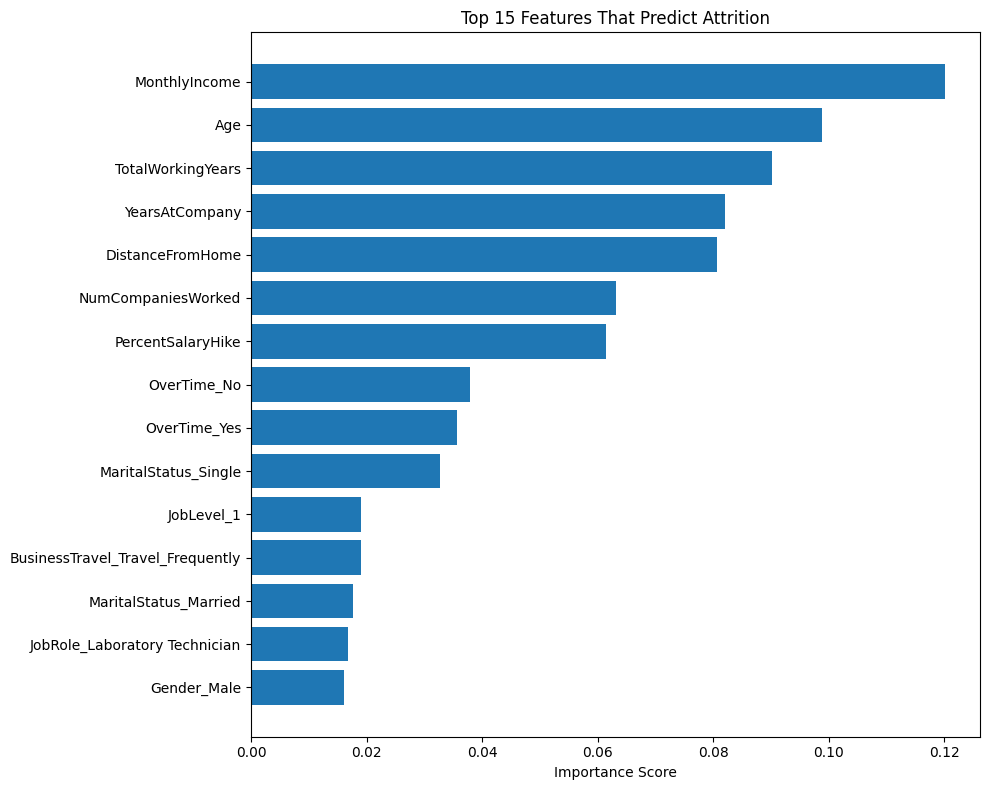


✅ Total features used by the model: 40
✅ Original numeric features: 7
✅ Categorical features after encoding: 33
   (Categories got expanded into multiple yes/no columns)



In [6]:

# FEATURE IMPORTANCE ANALYSIS
# Which features matter most for predicting attrition?

import matplotlib.pyplot as plt
import numpy as np

print("\n" + "=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Step 1: Get the trained Random Forest model from our pipeline
rf_model = best.named_steps['clf']

# Step 2: Get the list of all feature names
# The tricky part: our preprocessing step changed the features!
# - Numeric features (like Age, Income) stayed the same
# - Categorical features (like JobRole) got split into multiple columns
#   Example: JobRole became JobRole_Manager, JobRole_SalesRep, etc.

preprocessor = best.named_steps['pre']

# Get the numeric feature names (these didn't change)
numeric_features = NUM

# Get the categorical feature names AFTER they were transformed
# One-hot encoding created new columns for each category
cat_transformer = preprocessor.named_transformers_['cat']
cat_encoder = cat_transformer.named_steps['onehot']
cat_feature_names = cat_encoder.get_feature_names_out(CAT)

# Put all feature names together in one list
all_feature_names = list(numeric_features) + list(cat_feature_names)

# Step 3: Get the importance score for each feature
# Higher score = more important for predictions
importances = rf_model.feature_importances_

# Step 4: Create a table showing features and their importance
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)  # Sort from most to least important

# Step 5: Display the top 20 most important features
print("\nTop 20 Most Important Features:")
print("(Higher importance = bigger impact on predictions)")
print(importance_df.head(20).to_string(index=False))

# Step 6: Create a bar chart showing the top 15 features
plt.figure(figsize=(10, 8))
top_15 = importance_df.head(15)

# Create horizontal bars (easier to read feature names)
plt.barh(range(len(top_15)), top_15['Importance'])
plt.yticks(range(len(top_15)), top_15['Feature'])
plt.xlabel('Importance Score')
plt.title('Top 15 Features That Predict Attrition')
plt.gca().invert_yaxis()  # Put highest importance at the top
plt.tight_layout()
plt.show()

# Step 7: Show summary counts
print(f"\n✅ Total features used by the model: {len(all_feature_names)}")
print(f"✅ Original numeric features: {len(numeric_features)}")
print(f"✅ Categorical features after encoding: {len(cat_feature_names)}")
print(f"   (Categories got expanded into multiple yes/no columns)")
print("\n" + "=" * 60)

In [5]:
# Use config paths and create directory if needed
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# Save model
model_path = ARTIFACTS_DIR / "rf_pipeline.joblib"
joblib.dump(best, model_path)

# Save features
features_path = ARTIFACTS_DIR / "features.json"
with open(features_path, "w") as f:
    json.dump(NUM + CAT, f)

print(f"✅ Model exported → {model_path}")
print(f"✅ Features exported → {features_path}")

✅ Model exported → /Users/ahmedgodah/Documents/vscode-projects/AttriSight/artifacts/v1/rf_pipeline.joblib
✅ Features exported → /Users/ahmedgodah/Documents/vscode-projects/AttriSight/artifacts/v1/features.json
